In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Dropout
from tensorflow.keras.layers import Lambda, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  

2025-05-12 09:55:42.607616: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 09:55:42.614510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747032942.622789    4546 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747032942.625150    4546 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 09:55:42.634158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
def visualize_loaded_data(image, mask):
    """Visualize a single image and its corresponding mask."""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image[..., 0], cmap="gray")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask[..., 0], cmap="gray")
    plt.axis("off")
    
    plt.show()
    
def parse_tfrecord(example_proto, lower=201, upper=205):
    """
    Parses a single example from a TFRecord file and converts the mask to binary.
    """
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_png(parsed_example['image'], channels=1)
    mask = tf.io.decode_png(parsed_example['mask'], channels=1)

    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.cast(mask, tf.uint8)
    mask_binary = tf.where((mask >= lower) & (mask <= upper), 1, 0)

    return image, mask_binary


def load_tfrecord_dataset_for_inspection(tfrecord_dir):
    """Loads a dataset from TFRecord files for inspection."""
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

Visualizing sample 1
image shape before cropping (512, 512, 1)


I0000 00:00:1747032943.925111    4546 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-05-12 09:55:44.016462: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


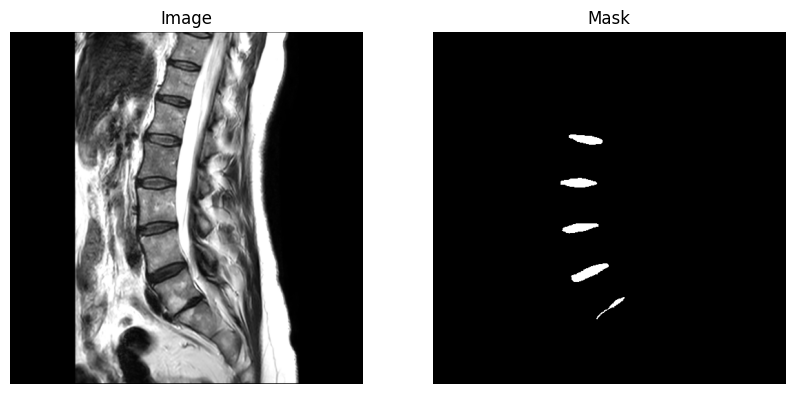

image shape after cropping (416, 416, 1)


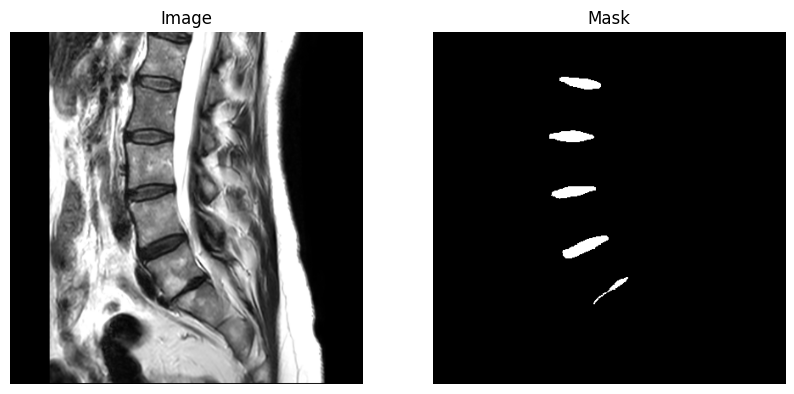

2025-05-12 09:55:44.218880: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
tfrecord_dir = "/root/tfrecords/tfrecords"
loaded_dataset = load_tfrecord_dataset_for_inspection(tfrecord_dir)

for idx, (image, mask) in enumerate(loaded_dataset.shuffle(10).take(1)): 
    print(f"Visualizing sample {idx + 1}")
    print(f"image shape before cropping {image.numpy().shape}")
    visualize_loaded_data(image.numpy(), mask.numpy())
    
    cropped_image = image[96:, 48:-48, :]
    cropped_mask = mask[96:, 48:-48, :]
    print(f"image shape after cropping {cropped_image.numpy().shape}")
    visualize_loaded_data(cropped_image.numpy(), cropped_mask.numpy())

In [ ]:
def crop_image_and_mask(image, mask):
    cropped_image = image[96:, 48:-48, :]
    cropped_mask = mask[96:, 48:-48, :]
    return cropped_image, cropped_mask
    
def load_tfrecord_dataset(tfrecord_dir, batch_size, buffer_size=100):
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(crop_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def split_dataset(dataset, train_samples, val_samples, batch_size):
    train_batches = train_samples // batch_size
    val_batches = val_samples // batch_size

    train_dataset = dataset.take(train_batches)
    val_dataset = dataset.skip(train_batches).take(val_batches)
    test_dataset = dataset.skip(train_batches + val_batches)

    return train_dataset, val_dataset, test_dataset

def count_samples_in_tfrecord(tfrecord_dir):
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    return sum(1 for _ in tf.data.TFRecordDataset(tfrecord_files))

In [ ]:
batch_size = 8
tfrecord_dir = "/root/tfrecords/tfrecords"
full_dataset = load_tfrecord_dataset(tfrecord_dir, batch_size=batch_size)

total_samples = count_samples_in_tfrecord(tfrecord_dir)
print(f"Total samples {total_samples}")
train_samples = int(0.8 * total_samples) 
test_samples = int(0.1 * total_samples) 
val_samples = total_samples - (train_samples + test_samples) 

train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_samples, val_samples, batch_size)
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.repeat().prefetch(tf.data.AUTOTUNE)

Total samples 1050


2025-05-12 09:55:44.384977: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable()
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    return (2. * intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    return (intersection + epsilon) / (union + epsilon)

@tf.keras.utils.register_keras_serializable() 
def channel_avg_pool(x):
    """Calculates the average across the channel axis."""
    return tf.reduce_mean(x, axis=-1, keepdims=True)

@tf.keras.utils.register_keras_serializable() 
def channel_max_pool(x):
    """Calculates the maximum across the channel axis."""
    return tf.reduce_max(x, axis=-1, keepdims=True)

def spatial_attention(input_feature, name_prefix): 
    """
    Applies spatial attention mechanism. Uses a name_prefix
    to ensure unique layer names when used multiple times.
    """
    avg_pool = Lambda(channel_avg_pool, name=f'{name_prefix}_channel_avg_pool')(input_feature)
    max_pool = Lambda(channel_max_pool, name=f'{name_prefix}_channel_max_pool')(input_feature)

    concat = Concatenate(axis=-1, name=f'{name_prefix}_concat')([avg_pool, max_pool])
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid',
                       name=f'{name_prefix}_conv')(concat)
    output = Multiply(name=f'{name_prefix}_multiply')([input_feature, attention])
    return output

In [ ]:
def build_binary_model(input_shape=(512, 512, 1)):
    inputs = Input(input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    c1 = Dropout(0.3)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (5, 5), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (5, 5), activation='relu', padding='same')(c2)
    c2 = Dropout(0.3)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (7, 7), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (7, 7), activation='relu', padding='same')(c3)
    c3 = Dropout(0.3)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(64, (9, 9), activation='relu', padding='same')(p3)
    c4 = Conv2D(64, (9, 9), activation='relu', padding='same')(c4)
    c4 = Dropout(0.4)(c4) 

    u5 = UpSampling2D((2, 2))(c4)
    c3_att = spatial_attention(c3, name_prefix='sa_c3')
    u5 = Concatenate()([u5, c3_att])
    c5 = Conv2D(64, (7, 7), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (7, 7), activation='relu', padding='same')(c5)
    c5 = Dropout(0.3)(c5)

    u6 = UpSampling2D((2, 2))(c5)
    c2_att = spatial_attention(c2, name_prefix='sa_c2') 
    u6 = Concatenate()([u6, c2_att])
    c6 = Conv2D(32, (5, 5), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (5, 5), activation='relu', padding='same')(c6)
    c6 = Dropout(0.3)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    c1_att = spatial_attention(c1, name_prefix='sa_c1')
    u7 = Concatenate()([u7, c1_att])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.3)(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=combo_loss, metrics=[dice_coefficient, 'accuracy'])

    return model

In [ ]:
model = build_binary_model(input_shape=(416, 416, 1))
model.summary()

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

checkpoint = ModelCheckpoint("segmentation_model_best.keras", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=2, restore_best_weights=True, verbose=1)

model.fit(train_dataset, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=50, callbacks=[checkpoint, early_stopping], verbose=1)

print("Model training complete. Best model saved as 'segmentation_model_best.keras'.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 416, 416,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 416, 416,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 416, 416,  │          0 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 208, 208,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 208, 208,  │     12,832 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 208, 208,  │     25,632 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 208, 208,  │          0 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 104, 104,  │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 104, 104,  │    100,416 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 104, 104,  │    200,768 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 104, 104,  │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 52, 52,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │    331,840 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sa_c3_channel_avg_… │ (None, 104, 104,  │          0 │ dropout_2[0][0]   │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sa_c3_channel_max_… │ (None, 104, 104,  │          0 │ dropout_2[0][0]   │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 52, 52,    │    331,840 │ conv2d_6[0][0]  

 Total params: 1,720,074 (6.56 MB)

 Trainable params: 1,720,074 (6.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1747032947.402715    4721 service.cc:148] XLA service 0x7f253001fe40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747032947.402812    4721 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-05-12 09:55:47.465033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747032947.746495    4721 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/105 ━━━━━━━━━━━━━━━━━━━━ 24:47 14s/step - accuracy: 0.4287 - dice_coefficient: 0.0372 - loss: 1.6566

I0000 00:00:1747032959.628725    4721 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9492 - dice_coefficient: 0.0853 - loss: 1.1375
Epoch 1: val_loss improved from inf to 0.43045, saving model to segmentation_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9494 - dice_coefficient: 0.0867 - loss: 1.1353 - val_accuracy: 0.9876 - val_dice_coefficient: 0.6324 - val_loss: 0.4305
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9875 - dice_coefficient: 0.6759 - loss: 0.3834
Epoch 2: val_loss improved from 0.43045 to 0.24822, saving model to segmentation_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9875 - dice_coefficient: 0.6763 - loss: 0.3830 - val_accuracy: 0.9928 - val_dice_coefficient: 0.7737 - val_loss: 0.2482
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9925 - dice_coefficient: 0.7949 - loss: 0.2426
Epoch 3: val_loss improved from 0.24822 to 0.21176, saving model to segmentation_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━

In [ ]:
results = model.evaluate(test_dataset, verbose=1)

test_loss = results[0]  
test_dice_coefficient = results[1]   
test_acc = results[2]  

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Dice Coefficient: {test_dice_coefficient}")

for images, labels in test_dataset.take(1): 
    predictions = model.predict(images)

    for i in range(len(images)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

print("Testing complete.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


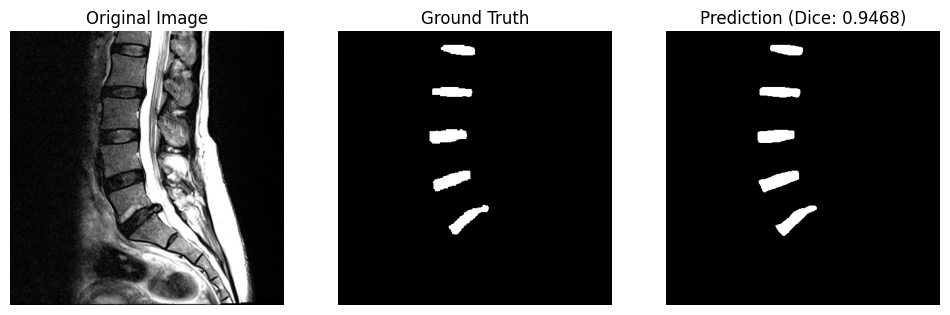

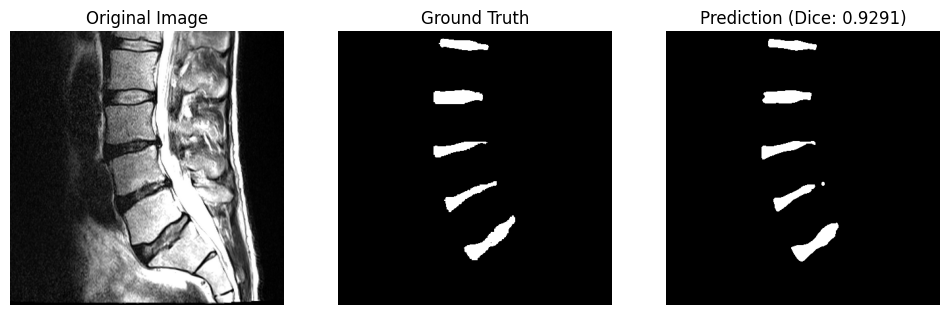

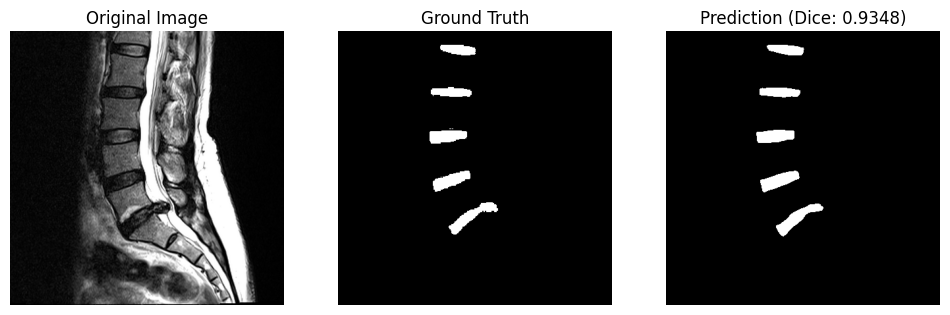

In [ ]:
for images, labels in test_dataset.take(3):
    predictions = model.predict(images)
    
    image = images[0].numpy().squeeze()
    label = labels[0].numpy().squeeze()
    prediction = predictions[0].squeeze()

    prediction_binary = (prediction > 0.5).astype(np.float32)

    dice_score = dice_coefficient(label, prediction_binary).numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_binary, cmap="gray")
    plt.title(f"Prediction (Dice: {dice_score:.4f})")
    plt.axis("off")